In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [2]:
dataFraud = pd.read_csv('../MachineLearning/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
dataFraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0


In [3]:
address2country = pd.read_csv('../MachineLearning/IpAddress_to_Country.csv')
address2country

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [4]:
dataFraud['ip_address'] = dataFraud['ip_address'].apply(lambda x: int(x))
address2country['lower_bound_ip_address'] = address2country['lower_bound_ip_address'].apply(lambda x: int(x))

# Create a temporary column to use for merging
dataFraud['temp_ip'] = dataFraud['ip_address']

# Merge the two datasets and print the first 5 rows
mergedData = pd.merge_asof(dataFraud.sort_values('temp_ip'),
                            address2country.sort_values('lower_bound_ip_address'),
                            left_on='temp_ip',
                            right_on='lower_bound_ip_address',
                            direction='forward',
                            allow_exact_matches=True)

# Drop the temporary column and unnecessary columns
mergedData = mergedData.drop(['temp_ip', 'upper_bound_ip_address'], axis=1)
mergedData

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,16777216.0,Australia
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,16777216.0,Australia
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,16777216.0,Australia
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,16777216.0,Australia
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,16777216.0,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,361167,2015-04-16 05:00:09,2015-07-31 21:21:47,39,DDZWCUYTHKALI,Direct,FireFox,F,36,4294673680,0,NaN,NaN
151108,62422,2015-08-08 06:25:41,2015-08-28 04:01:06,62,YJLXUZPSHUOOS,SEO,IE,M,22,4294714854,0,NaN,NaN
151109,260255,2015-02-18 21:07:18,2015-04-25 06:20:38,17,LPIWPXJCMYJOT,SEO,FireFox,M,19,4294719533,0,NaN,NaN
151110,172984,2015-08-15 15:40:46,2015-10-30 09:47:39,9,TSDCMHPWAUZAR,Ads,IE,F,35,4294822241,0,NaN,NaN


In [15]:
dataFraud['signup_time'] = pd.to_datetime(dataFraud['signup_time'])
dataFraud['purchase_time'] = pd.to_datetime(dataFraud['purchase_time'])
dataFraud['time_difference'] = dataFraud['purchase_time'] - dataFraud['signup_time']
dataFraud[['signup_time', 'purchase_time', 'time_difference']].head()

,signup_time,purchase_time,time_difference
0,2015-02-24 22:55:49,2015-04-18 02:47:11,52 days 03:51:22
1,2015-06-07 20:39:50,2015-06-08 01:38:54,0 days 04:59:04
2,2015-01-01 18:52:44,2015-01-01 18:52:45,0 days 00:00:01
3,2015-04-28 21:13:25,2015-05-04 13:54:50,5 days 16:41:25
4,2015-07-21 07:09:52,2015-09-09 18:40:53,50 days 11:31:01


In [7]:
UserDeviceCount = dataFraud.groupby('user_id')['device_id'].nunique()
UserDeviceCount

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: device_id, Length: 151112, dtype: int64

In [8]:
userIpCount = dataFraud.groupby('user_id')['ip_address'].nunique()
userIpCount

user_id
2         1
4         1
8         1
9         1
12        1
         ..
399992    1
399993    1
399995    1
399997    1
400000    1
Name: ip_address, Length: 151112, dtype: int64

In [14]:
dataFraud['signup_time'] = pd.to_datetime(dataFraud['signup_time'])
dataFraud['purchase_time'] = pd.to_datetime(dataFraud['purchase_time'])
dataFraud['signup_day'] = dataFraud['signup_time'].dt.day
dataFraud['signup_week'] = dataFraud['signup_time'].dt.isocalendar().week
dataFraud['purchase_day'] = dataFraud['purchase_time'].dt.day
dataFraud['purchase_week'] = dataFraud['purchase_time'].dt.isocalendar().week
dataFraud[['signup_day', 'signup_week', 'purchase_day', 'purchase_week']].head()

,signup_day,signup_week,purchase_day,purchase_week
0,24,9,18,16
1,7,23,8,24
2,1,1,1,1
3,28,18,4,19
4,21,30,9,37


In [16]:
features = ['purchase_value', 'source', 'browser', 'sex', 'age']
target = 'class'

X = dataFraud[features]
y = dataFraud[target]

print("Features (X):\n", X.head())
print("\nTarget (y):\n", y.head())

Features (X):
    purchase_value source browser sex  age
0              34    SEO  Chrome   M   39
1              16    Ads  Chrome   F   53
2              15    SEO   Opera   M   53
3              44    SEO  Safari   M   41
4              39    Ads  Safari   M   45

Target (y):
 0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 105778
Test set size: 45334


In [18]:
dataFraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,temp_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,732758368,24,9,18,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,350311387,7,23,8,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,2621473820,1,1,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,3840542443,28,18,4,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,415583117,21,30,9,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3451154526,1,3451154526,27,5,29,13
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2439047221,0,2439047221,15,20,26,22
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2748470523,0,2748470523,3,10,20,21
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3601174708,0,3601174708,9,28,7,37


In [20]:
# Define the features and target
features = ['purchase_value', 'source', 'browser', 'sex', 'age', ]
target = 'class'

# Create the feature matrix (X) and target vector (y)
X = dataFraud[features]
y = dataFraud[target]

# Print the first few rows of X and y to verify
print("Features (X):\n", X.head())
print("\nTarget (y):\n", y.head())


Features (X):
    purchase_value source browser sex  age
0              34    SEO  Chrome   M   39
1              16    Ads  Chrome   F   53
2              15    SEO   Opera   M   53
3              44    SEO  Safari   M   41
4              39    Ads  Safari   M   45

Target (y):
 0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.13" 2021-10-19 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.13+10-LTS-370); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.13+10-LTS-370, mixed mode)
  Starting server from /opt/homebrew/Cellar/jupyterlab/4.0.1/libexec/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/v6/5lgwn_nn5732nl9zywh18gr40000gn/T/tmpk1ehbv1h
  JVM stdout: /var/folders/v6/5lgwn_nn5732nl9zywh18gr40000gn/T/tmpk1ehbv1h/h2o_anthropophobe_started_from_python.out
  JVM stderr: /var/folders/v6/5lgwn_nn5732nl9zywh18gr40000gn/T/tmpk1ehbv1h/h2o_anthropophobe_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_anthropophobe_juhhv3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


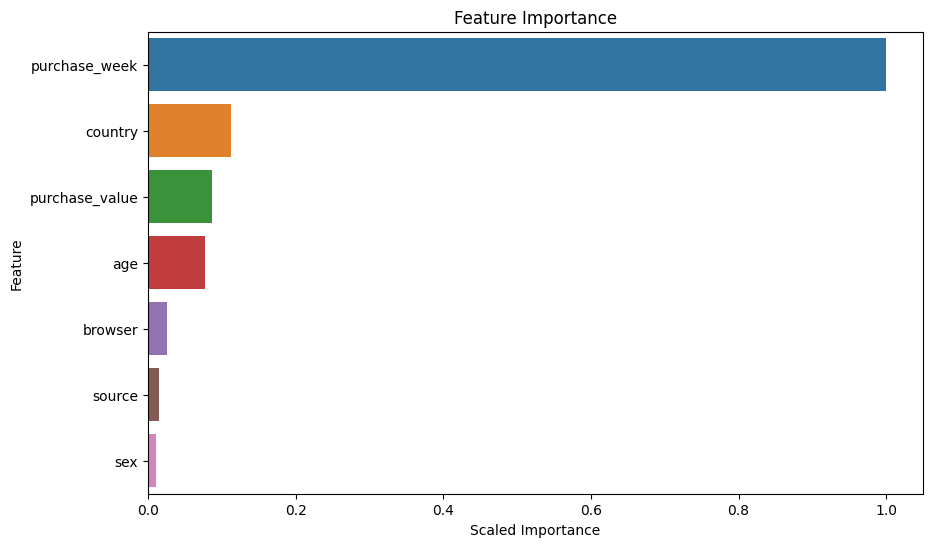

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     40965
           1       0.98      0.54      0.69      4214

    accuracy                           0.96     45179
   macro avg       0.97      0.77      0.83     45179
weighted avg       0.96      0.96      0.95     45179



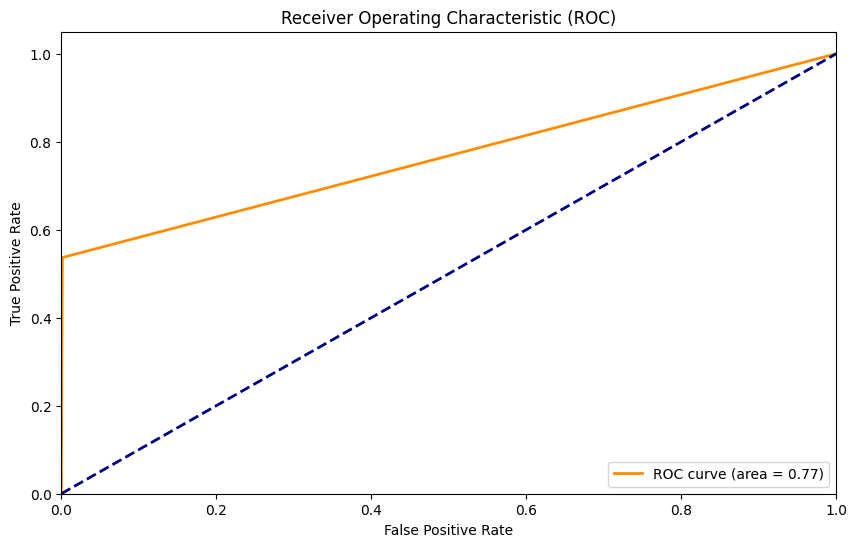

H2O session _sid_b2f7 closed.


/var/folders/v6/5lgwn_nn5732nl9zywh18gr40000gn/T/ipykernel_3293/4107521458.py:84: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [22]:
import pandas as pd
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'merged_data' with the relevant columns
# Replace this with your actual data loading code

# Calculate time difference
mergedData['time_difference'] = mergedData['purchase_time'] - mergedData['signup_time']

# Calculate device number per user
device_counts = mergedData.groupby('user_id')['device_id'].nunique()
mergedData['device_number'] = mergedData['user_id'].map(device_counts)

# Extract purchase week
mergedData['purchase_week'] = mergedData['purchase_time'].dt.isocalendar().week

# Initialize H2O
h2o.init()

# Convert Pandas DataFrame to H2O Frame
h2o_df = h2o.H2OFrame(mergedData)
h2o_df['class'] = h2o_df['class'].asfactor()  # Convert target to factor (categorical) for classification

# Split the data into training and test sets
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.7], seed=42)

# Define the features and target
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country',
            'time_difference', 'device_number', 'purchase_week']
target = 'class'

# Define the model parameters
model = H2ORandomForestEstimator(ntrees=100, max_depth=20, nfolds=5, seed=42)

# Train the model
model.train(x=features, y=target, training_frame=train_h2o)

# Get the feature importance scores
feature_importance = model.varimp(use_pandas=True)

# Plot feature importance using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='scaled_importance', y='variable', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Scaled Importance')
plt.ylabel('Feature')
plt.show()

# Make predictions on the test set
predictions = model.predict(test_h2o)
y_pred = predictions.as_data_frame()['predict'].values

# Convert H2O Frame to Pandas DataFrame for the test set
test_df = test_h2o.as_data_frame()

# Extract the actual target values from the test set
y_true = test_df[target]

# Generate the classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Shutdown H2O
h2o.shutdown()
